# Uncomment for Google Colab

# Basic Example

## Initialize the `HDF5Client`

In [1]:
from colabfit.tools.client import HDF5Client

client = HDF5Client('basic_example.hdf5', 'w', driver='core', drop_mongo=True)

## Attaching a property definition

In [2]:
client.insert_property_definition({
    'property-id': 'energy-forces',
    'property-title': 'A default property for storing energies and forces',
    'property-description': 'Energies and forces computed using DFT',
    'energy': {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Cohesive energy'},
    'forces': {'type': 'float', 'has-unit': True, 'extent': [':',3], 'required': True, 'description': 'Atomic forces'},
})

/home/jvita/scripts/colabfit-tools/colabfit/tools/hdf5_backend.py:1296: UserWarning: Invalid KIM property-id; Temporarily renaming to tag:@,0000-00-00:property/energy-forces
  warnings.warn(f"Invalid KIM property-id; Temporarily renaming to {dummy_dict['property-id']}")


In [3]:
client.get_property_definition('energy-forces')['definition']

{'property-id': 'energy-forces',
 'property-title': 'A default property for storing energies and forces',
 'property-description': 'Energies and forces computed using DFT',
 'energy': {'type': 'float',
  'has-unit': True,
  'extent': [],
  'required': True,
  'description': 'Cohesive energy'},
 'forces': {'type': 'float',
  'has-unit': True,
  'extent': [':', 3],
  'required': True,
  'description': 'Atomic forces'}}

## Attaching property settings

In [4]:
from colabfit.tools.property_settings import PropertySettings

pso = PropertySettings(
    method='VASP',
    description='A basic VASP calculation',
    files=None,
    labels=['PBE', 'GGA'],
)

pso_id = client.insert_property_settings(pso)
pso_id

'-8136543487582617353'

## Adding data

### Generating configurations

#### Manually

In [5]:
import numpy as np
from ase import Atoms

images = []
for i in range(1, 1000):
    atoms = Atoms('H'*i, positions=np.random.random((i, 3)))

    atoms.info['_name'] = 'configuration_' + str(i)
    
    atoms.info['dft_energy'] = i*i
    atoms.arrays['dft_forces'] = np.random.normal(size=(i, 3))
    

    images.append(atoms)

#### Using `load_data()`

In [6]:
from ase.io import write

# outfile = '/content/example.extxyz'   # use this line for ColabFit
outfile = '/tmp/example.extxyz'   # use this line for local runs

write(outfile, images)  # use this line for local runs

In [7]:
from colabfit.tools.client import load_data

images = load_data(
    file_path=outfile,  # use this line for local runs
    file_format='xyz',
    name_field='_name',
    elements=['H'],
    default_name=None,
)

### Defining a `property_map`

In [8]:
property_map = {
    # property name
    'energy-forces': {
        # property field: {'field': configuration info/arrays field, 'units': field units}
        'energy': {'field': 'dft_energy', 'units': 'eV'},
        'forces': {'field': 'dft_forces', 'units': 'eV/Ang'},
    }
}

### `insert_data()`

In [9]:
ids = list(client.insert_data(
    images,
    property_map=property_map,
    property_settings={'energy-forces': pso_id},
    generator=True,
    verbose=True
))

/home/jvita/scripts/colabfit-tools/colabfit/tools/client.py:219: UserWarning: The generator version of insert_data has not been implemented yet; just using the in-memory version
  warnings.warn(
Inserting data in HDF5 backend: 0it [00:00, ?it/s]/home/jvita/scripts/colabfit-tools/colabfit/tools/property.py:231: UserWarning: Invalid KIM property-id; Temporarily renaming to tag:@,0000-00-00:property/energy-forces
  warnings.warn(f"Invalid KIM property-id; Temporarily renaming to {dummy_dict['property-id']}")
Inserting data in HDF5 backend: 999it [00:13, 76.33it/s] 
Adding configurations to Mongo: 999it [00:01, 633.20it/s]
Adding properties to Mongo: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:03<00:00, 311.54it/s]
Adding CO<->PR relationships to Mongo: 999it [00:01, 979.89it/s]


In [10]:
client.configurations.count_documents({})

999

In [11]:
len(client.database['configurations/ids/data'])

999

In [12]:
configurations = list(client.get_configurations('all', verbose=True, generator=True))

Loading configurations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:02<00:00, 362.87it/s]


## Defining a `ConfigurationSet`

In [13]:
co_ids = [_['_id'] for _ in client.configurations.find({'nsites': {'$lt': 100}}, {'_id': 1})]

In [14]:
next(client.configurations.find({'_id': co_ids[-1]}))

{'_id': '-8156403966521175968',
 'chemical_formula_anonymous': 'A',
 'chemical_formula_hill': 'H99',
 'chemical_formula_reduced': 'H',
 'dimension_types': [0, 0, 0],
 'elements': ['H'],
 'elements_ratios': [1.0],
 'labels': [],
 'last_modified': '2021-12-15T09:56:54Z',
 'lattice_vectors': [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]],
 'names': ['configuration_99'],
 'nelements': 1,
 'nperiodic_dimensions': 0,
 'nsites': 99,
 'relationships': {'properties': ['6224370801224869448']}}

In [15]:
cs_id = client.insert_configuration_set(co_ids, description='Configurations with fewer than 100 atoms')
cs_id

'-7858053835319287245'

In [16]:
cs = client.get_configuration_set(cs_id)['configuration_set']

In [17]:
cs.description

'Configurations with fewer than 100 atoms'

In [18]:
for k,v in cs.aggregated_info.items():
    print(k, v)

nconfigurations 99
nsites 4950
nelements 1
elements ['H']
individual_elements_ratios [[1.0]]
total_elements_ratios [1.0]
labels []
labels_counts []
chemical_formula_reduced ['H']
chemical_formula_anonymous ['A']
chemical_formula_hill ['H99', 'H30', 'H82', 'H74', 'H76', 'H56', 'H40', 'H44', 'H36', 'H10', 'H34', 'H29', 'H7', 'H85', 'H39', 'H78', 'H49', 'H9', 'H64', 'H87', 'H71', 'H63', 'H11', 'H73', 'H52', 'H89', 'H53', 'H77', 'H33', 'H83', 'H41', 'H80', 'H60', 'H17', 'H24', 'H25', 'H45', 'H47', 'H42', 'H59', 'H54', 'H26', 'H48', 'H23', 'H50', 'H68', 'H97', 'H4', 'H75', 'H96', 'H13', 'H21', 'H12', 'H', 'H94', 'H32', 'H81', 'H72', 'H16', 'H91', 'H8', 'H55', 'H46', 'H35', 'H67', 'H14', 'H61', 'H58', 'H70', 'H93', 'H6', 'H20', 'H79', 'H31', 'H19', 'H98', 'H43', 'H92', 'H66', 'H95', 'H27', 'H57', 'H37', 'H69', 'H62', 'H38', 'H65', 'H90', 'H22', 'H15', 'H84', 'H88', 'H5', 'H28', 'H18', 'H2', 'H3', 'H51', 'H86']
nperiodic_dimensions [0]
dimension_types [[0, 0, 0]]


## Applying labels to configurations

In [19]:
client.apply_configuration_labels({'nsites': {'$lt': 100}}, {'small'}, verbose=True)

Applying configuration labels: 99it [00:00, 535.36it/s]


Note: need to resync the configuration set document

In [20]:
cs = client.get_configuration_set(cs_id)['configuration_set']
cs.aggregated_info['labels']

[]

In [21]:
cs = client.get_configuration_set(cs_id, resync=True)['configuration_set']
cs.aggregated_info['labels']

['small']

In [22]:
client.apply_configuration_labels({}, {'random_data'}, verbose=True)

Applying configuration labels: 999it [00:01, 684.85it/s]


In [23]:
cs = client.get_configuration_set(cs_id, resync=True)['configuration_set']
cs.aggregated_info['labels']

['small', 'random_data']

## Creating a `Dataset` from scratch

In [24]:
co_ids1 = [_['_id'] for _ in client.configurations.find({'nsites': {'$lt': 100}})]
co_ids2 = [_['_id'] for _ in client.configurations.find({'nsites': {'$gte': 100}})]

print(len(co_ids1))
print(len(co_ids2))

99
900


In [25]:
cs_id1 = client.insert_configuration_set(co_ids1, 'Small configurations')
cs_id2 = client.insert_configuration_set(co_ids2, 'Big configurations')

In [26]:
pr_ids = [
    _['_id'] for _ in client.properties.find(
        {'relationships.configurations': {'$elemMatch': {'$in': co_ids1+co_ids2}}},
        {'_id': 1}
    )
]
len(pr_ids)

999

In [27]:
ds_id = client.insert_dataset(
    cs_ids=[cs_id1, cs_id2],
    pr_ids=pr_ids,
    authors=['J. E. Lennard-Jones'],
    links=['https://en.wikipedia.org/wiki/John_Lennard-Jones'],
    description="This is an example dataset",
    resync=True
)
ds_id

'5303680887737325699'

In [28]:
dsdoc = next(client.datasets.find({'_id': ds_id}))

for k,v in dsdoc['aggregated_info'].items():
    print(k,v)

nconfigurations 999
nsites 499500
nelements 1
elements ['H']
individual_elements_ratios [[1.0]]
total_elements_ratios [1.0]
configuration_labels ['random_data', 'small']
configuration_labels_counts [999, 99]
chemical_formula_reduced ['H']
chemical_formula_anonymous ['A']
chemical_formula_hill ['H366', 'H897', 'H164', 'H692', 'H859', 'H426', 'H74', 'H218', 'H706', 'H10', 'H857', 'H326', 'H782', 'H274', 'H311', 'H764', 'H85', 'H377', 'H741', 'H986', 'H681', 'H210', 'H723', 'H155', 'H206', 'H141', 'H517', 'H336', 'H202', 'H785', 'H71', 'H443', 'H573', 'H342', 'H957', 'H863', 'H533', 'H952', 'H127', 'H890', 'H11', 'H52', 'H498', 'H814', 'H324', 'H89', 'H108', 'H428', 'H388', 'H488', 'H793', 'H619', 'H117', 'H367', 'H889', 'H743', 'H41', 'H503', 'H209', 'H664', 'H527', 'H954', 'H987', 'H24', 'H471', 'H115', 'H383', 'H582', 'H355', 'H226', 'H269', 'H888', 'H508', 'H372', 'H200', 'H914', 'H47', 'H289', 'H945', 'H161', 'H160', 'H989', 'H198', 'H647', 'H866', 'H535', 'H344', 'H579', 'H174', 'H4

In [29]:
dataset = client.get_dataset(ds_id)['dataset']

In [30]:
dataset.aggregated_info

{'nconfigurations': 999,
 'nsites': 499500,
 'nelements': 1,
 'elements': ['H'],
 'individual_elements_ratios': [[1.0]],
 'total_elements_ratios': [1.0],
 'configuration_labels': ['random_data', 'small'],
 'configuration_labels_counts': [999, 99],
 'chemical_formula_reduced': ['H'],
 'chemical_formula_anonymous': ['A'],
 'chemical_formula_hill': ['H366',
  'H897',
  'H164',
  'H692',
  'H859',
  'H426',
  'H74',
  'H218',
  'H706',
  'H10',
  'H857',
  'H326',
  'H782',
  'H274',
  'H311',
  'H764',
  'H85',
  'H377',
  'H741',
  'H986',
  'H681',
  'H210',
  'H723',
  'H155',
  'H206',
  'H141',
  'H517',
  'H336',
  'H202',
  'H785',
  'H71',
  'H443',
  'H573',
  'H342',
  'H957',
  'H863',
  'H533',
  'H952',
  'H127',
  'H890',
  'H11',
  'H52',
  'H498',
  'H814',
  'H324',
  'H89',
  'H108',
  'H428',
  'H388',
  'H488',
  'H793',
  'H619',
  'H117',
  'H367',
  'H889',
  'H743',
  'H41',
  'H503',
  'H209',
  'H664',
  'H527',
  'H954',
  'H987',
  'H24',
  'H471',
  'H115',
  

## Exploring the data

In [31]:
client.get_statistics('properties/energy-forces/energy')

{'average': 333166.6666666667,
 'std': 297825.4616195346,
 'min': 1.0,
 'max': 998001.0,
 'average_abs': 333166.6666666667}

In [32]:
client.get_statistics('properties/energy-forces/forces')

{'average': -0.0002799457163229893,
 'std': 0.99983763954048,
 'min': -4.66618147,
 'max': 5.2052332,
 'average_abs': 0.7976558260286487}

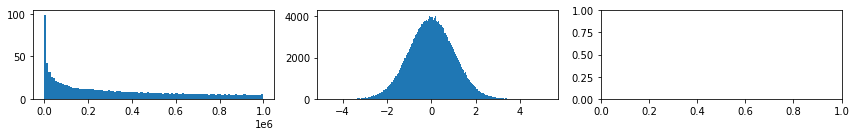

In [33]:
fig = client.plot_histograms(['properties/energy-forces/energy', 'properties/energy-forces/forces'])